In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [2]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

collectgarbage()

### Render labels for displaying

In [358]:
function renderLabels(labels, img, blendCoeff)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
--             if not LUT[labels[{i,j}]] then
--                 print(labels[{i,j}], i, j)
--             end
            for k, color in ipairs(LUT[labels[{i,j}]]) do
                retval[{k,i,j}] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = blendCoeff or 0.62
        retval:mul(labelsBlendCoeff)
        
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        img:mul(1 - labelsBlendCoeff)
        retval:add(img)
    end
    
    return retval
end

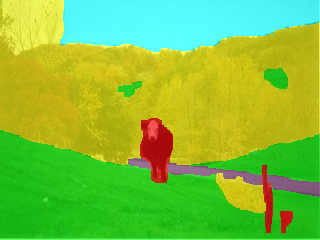

In [345]:
-- example blending
local k = 600
itorch.image(renderLabels(labels[k], images[k]))
-- itorch.image(comparePredictions(images[k], labels[k], predict(net, images[k])))

In [5]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [6]:
CUDA = true

In [7]:
Integral = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

In [8]:
net = torch.load('SB segmentation 2/net.t7')
losses = torch.load('SB segmentation 2/loss-history.t7')

In [9]:
net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(IntegralSmartNorm(12, 240, 320))
convPlusInt:add(nn.SpatialConvolutionMM(3, 3*12, 3,3, 1,1, 1,1))
net:add(convPlusInt) -- 3 -> 72

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(72, 12, 1,1,1,1)) -- 72 -> 12

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(IntegralSmartNorm(8, 240, 320))
convPlusInt2:add(nn.SpatialConvolutionMM(12, 12*6, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 12 -> 168

net:add(nn.LeakyReLU(0.01))
net:add(nn.SpatialConvolutionMM(168, 8, 1,1,1,1)) -- 168 -> 8

net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

if CUDA then
    require 'cunn'
    net:cuda()
end

In [10]:
params, gradParams = net:parameters()

In [11]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net:type())

In [28]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 0.43e-3 --1.08e-3
    if i <= 4 or (i >= 9 and i <= 12) then
        lr = 0.4--0.7
    end
    
    optimStates[i] = {
        learningRate = lr,
        learningRateDecay = 0.99945,
        momentum = 0.9
    }
end

In [13]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()

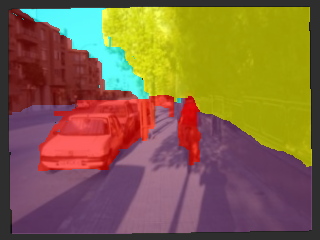

In [14]:
k =400
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [15]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0.4, 2.05}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [41]:
outputDir = 'SB segmentation smartnorm/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [18]:
losses = {}

In [350]:
evaluationIdx = {
    26,13,58,74,89,98,103,110,132,127,630, -- buildings
    30,21,31,64,71,88,681, -- water/sand
    12,91,678,693, -- mountain
    3,59,82,118,120,698,650 -- grass/trees
}

table.sort(evaluationIdx)

In [361]:
function evaluate(net, images, labels, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net:type())
        local outputs = net:forward(input)
        local target = labels[idx]:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:view(240, 320, 8):max(3)):squeeze():float()))
        end
        
        target = target:view(240*320)

        for i = 1,target:nElement() do
            if target[i] == 0 then
                target[i] = 3
                outputs[i]:zero()
                outputs[{i,3}] = 1e4
            end
        end

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

In [362]:
batchSize = 10
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 12 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 8 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 12 -- how oftern to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,98 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]], 
                torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(net:type())
            local outputs = net:forward(input)

            for i = 1,target:nElement() do
                if target[i] == 0 then
                    target[i] = 3
                    outputs[i]:zero()
                    outputs[{i,3}] = 1e4
                end
            end
            
            target = target:type(net:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        if iter < 13 and i == 1 then
            print('Param:' .. params[i][1])
--             print('Real param:' .. net:get(1):get(1).xMin[1])
--             print('Grad:' .. gradParams[i][1])
--             print('Real grad:' .. net:get(1):get(1).gradXMin[1])
--             print(torch.data(params[i]), torch.data(net:get(1):get(1).xMin))
        end
        optim.adam(feval, params[i], optimStates[i])
--         if iter < 13 and i == 1 then
--             print(torch.data(params[i]), torch.data(net:get(1):get(1).xMin))
--             print('Params after LR = ' .. optimStates[i].learningRate .. ':')
--             print('Param:' .. params[i][1])
--             print('Real param:' .. net:get(1):get(1).xMin[1])
--             print('')
--         end
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, images, labels, evaluationIdx,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/'))
        -- losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
    end
    
    if iter % 4 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 4 or -1) .. ', ' .. os.date()
        )
        avgLoss = 0
    end
end

Epoch 0	


Param:66.322624206543	


Param:66.330993652344	


Param:66.355567932129	


Param:66.394760131836	


Iteration 4, loss = 0.95531756096873, Thu Apr  6 21:23:27 2017	


Param:66.447128295898	


Param:66.511375427246	


Param:66.58634185791	


Param:66.670974731445	


Iteration 8, loss = 0.95531756096873, Thu Apr  6 21:24:01 2017	


Param:66.76432800293	


Param:66.865547180176	


Param:66.97386932373	


Param:67.088600158691	


Iteration 12, loss = 0.95531756096873, Thu Apr  6 21:24:29 2017	


Iteration 16, loss = 0.95531756096873, Thu Apr  6 21:25:05 2017	


Iteration 20, loss = 0.95531756096873, Thu Apr  6 21:25:39 2017	


Iteration 24, loss = 0.95531756096873, Thu Apr  6 21:26:10 2017	


Iteration 28, loss = 0.95531756096873, Thu Apr  6 21:26:53 2017	


Iteration 32, loss = 0.95531756096873, Thu Apr  6 21:27:21 2017	


Iteration 36, loss = 0.95531756096873, Thu Apr  6 21:27:48 2017	


Iteration 40, loss = 0.95531756096873, Thu Apr  6 21:28:28 2017	


Iteration 44, loss = 0.95531756096873, Thu Apr  6 21:28:58 2017	


Iteration 48, loss = 0.95531756096873, Thu Apr  6 21:29:30 2017	


Iteration 52, loss = 0.95531756096873, Thu Apr  6 21:30:10 2017	


Iteration 56, loss = 0.95531756096873, Thu Apr  6 21:30:41 2017	


Iteration 60, loss = 0.95531756096873, Thu Apr  6 21:31:16 2017	


Iteration 64, loss = 0.95531756096873, Thu Apr  6 21:31:57 2017	


Iteration 68, loss = 0.95531756096873, Thu Apr  6 21:32:24 2017	


Iteration 72, loss = 0.95531756096873, Thu Apr  6 21:32:51 2017	
Epoch 1	


Iteration 76, loss = 0.95531756096873, Thu Apr  6 21:33:30 2017	


Iteration 80, loss = 0.95531756096873, Thu Apr  6 21:33:56 2017	


Iteration 84, loss = 0.95531756096873, Thu Apr  6 21:34:21 2017	


Iteration 88, loss = 0.95531756096873, Thu Apr  6 21:34:50 2017	


Iteration 92, loss = 0.95531756096873, Thu Apr  6 21:35:10 2017	


Iteration 96, loss = 0.95531756096873, Thu Apr  6 21:35:33 2017	


In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}


In [360]:
function predict(net, example)
    local pred = net:forward(example:type(net:type()))
    return select(2, pred:view(240, 320, 8):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:clone():float()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [38]:
for i = 1,27 do
    local k = torch.random(715)
    image.savePNG(string.format(outputDir .. 'Images/%03d.png', k), comparePredictions(images[k], labels[k], predict(net, images[k])))
end